# Effects of User Type, Time and Day on the Average Ride Duration
## by Emmanuel Boluwaji Adeyeye

## Investigation Overview 

In this investigation, I wanted to look at the features that have the most effect on the average ride duration. The main focus was on the user type, start hour, and day of the week the rides were made. 


## Dataset Overview

This dataset contains information about 183,412 rides made in February 2022 in a bike-sharing system covering the greater San Francisco Bay area. The attributes include the start and end times of the rides, the year of birth of the user, and the user type. 8780 data points were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Convert start_time and end_time into DateTime datatypes,
#     and extract the hour and the day of the week 
#     from the start_time and end_time variables
for old_column in ['start_time', 'end_time']:
    df[old_column] = df[old_column].apply(lambda x: pd.to_datetime(x))
    df[old_column.split('_')[0] + '_hour'] = df[old_column].dt.hour
    df[old_column.split('_')[0] + '_day'] = df[old_column].dt.day_name()

In [4]:
from datetime import date

today = date.today()
df['member_age'] = today.year - df.member_birth_year

In [5]:
# Convert duration_sec to minute
df['duration_min'] = df.duration_sec / 60

In [6]:
# Drop rows with missing data
for column in df.columns:
    missing_vals = df.loc[df[column].isnull()]
    df.drop(missing_vals.index, axis=0, inplace=True)

In [7]:
# Drop rows with inconsistent data.
outliers = (df['duration_min'] > 450) | (df['member_age'] > 85)
df = df.loc[-outliers]

In [8]:
# Cut member_age into bins
df.member_age = pd.cut(df.member_age, bins=[20, 30, 40, 50, 60, 70, 80, 90],
                       labels=['21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-85'])

In [9]:
# Drop irrelevant columns
df.drop(['duration_sec', 'start_time', 'end_time', 'start_station_latitude',
         'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 
         'end_day', 'member_birth_year'],
        axis=1, inplace=True)

## Distribution of Ride Durations

Ride durations in the dataset take on a large range of values, from about 1 at the lowest, to about 450 at the highest. Plotted on a logarithmic scale, the distribution of ride durations takes on a unimodal shape.

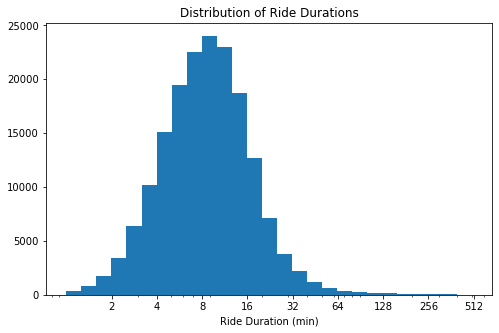

In [10]:
log_binsize = 0.1
bins = 10 ** np.arange(0, np.log10(df['duration_min'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.title('Distribution of Ride Durations')
plt.xscale('log')
plt.xticks([2, 4, 8, 16, 32, 64, 128, 256, 512], ['2', '4', '8', '16', '32', '64', '128', '256', '512'])
plt.xlabel('Ride Duration (min)')
plt.show()

## Percentage of user type

The user type has two values: Subscriber and customer. The subscribers pay a fixed amount monthly whereas the customers are charged a fixed amount for one-way trips per day. 90.5% of the rides were made by subscribers while customers made 9.5% of the rides.

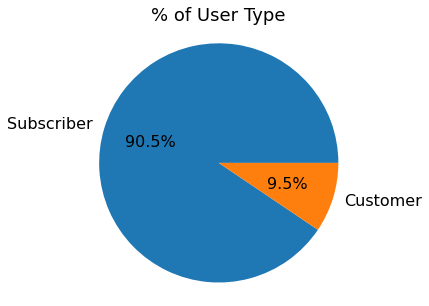

In [11]:
plt.figure(figsize=[8, 5])
plt.pie(x=df.user_type.value_counts(),
        labels=df.user_type.value_counts().index,
        autopct='%1.1f%%',
       radius=1.1, textprops={'fontsize': 16}
       )
plt.title(label='% of User Type', fontdict={'fontsize': 18})
plt.show()

## Average Ride Duration by User Type

The mean of the ride duration by customers is almost 100% higher than that of subscribers as depicted on the violin plots. This accounts for the base observation that the average duration of a ride made by a customer is longer than that of a subscriber.

In [12]:
# compute the logarithm of duration_min for other modeling and plotting
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df['log_duration'] = df['duration_min'].apply(log_trans)

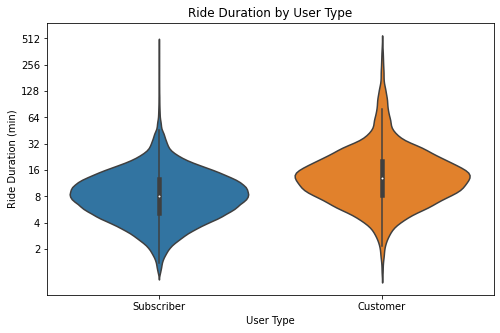

In [13]:
plt.figure(figsize=[8, 5])
sb.violinplot(data = df, x = 'user_type', y = 'log_duration')
plt.yticks(log_trans(np.array([2, 4, 8, 16, 32, 64, 128, 256, 512])), 
                     ['2', '4', '8', '16', '32', '64', '128', '256', '512'])
plt.xlabel('User Type')
plt.ylabel('Ride Duration (min)')
plt.title('Ride Duration by User Type')
plt.show()

## Average Ride Duration over Time

The average ride duration is highest at around 3 and lowest around 6 daily. It is also highest on weekends.

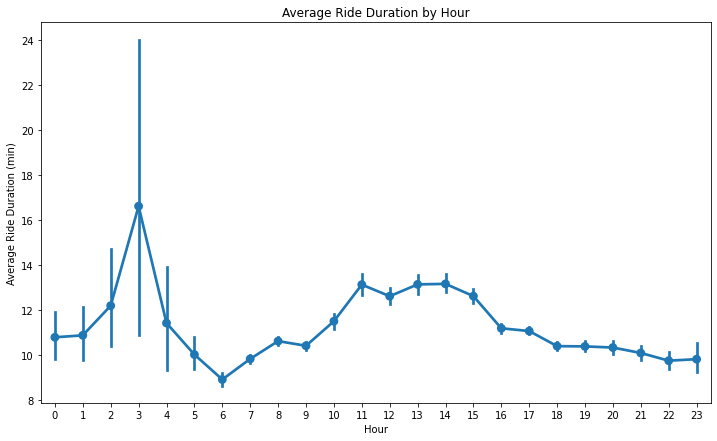

In [14]:
plt.figure(figsize=[12, 7])

sb.pointplot(data=df, x='start_hour', y='duration_min');
plt.xlabel('Hour')
plt.ylabel('Average Ride Duration (min)')
plt.title('Average Ride Duration by Hour')

plt.show()

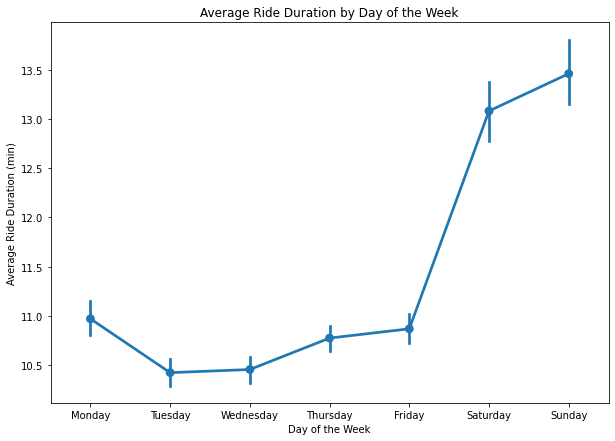

In [15]:
plt.figure(figsize=[10, 7])

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.pointplot(data=df, x = 'start_day', y = 'duration_min', order=weekdays)
plt.xlabel('Day of the Week')
plt.ylabel('Average Ride Duration (min)')
plt.title('Average Ride Duration by Day of the Week')
plt.show()

## User Type Over Time

The number of rides by subscribers around 8 and 17 looks almost the same. This shows that most of the people that made the rides around 8 were the ones that used the bike share service around 17. More rides were made by customers around 17 than every other hour. Subscribers majorly make more rides on weekdays whereas the number of customers' rides on weekends is not significantly different from that made on weekdays.

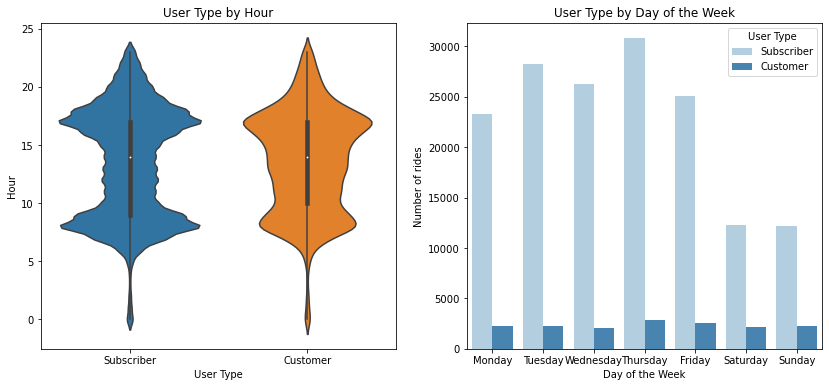

In [16]:
fig, ax = plt.subplots(ncols = 2, figsize = [14, 6])

sb.violinplot(data=df, y='start_hour', x='user_type', ax=ax[0])
ax[0].set_xlabel('User Type')
ax[0].set_ylabel('Hour')
ax[0].set_title('User Type by Hour')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(data = df, x = 'start_day', hue = 'user_type', palette = 'Blues', order=weekdays, ax=ax[1])
ax[1].set_xlabel('Day of the Week')
ax[1].set_ylabel('Number of rides')
ax[1].set_title('User Type by Day of the Week')
ax[1].legend(title='User Type')

plt.show()

## Average Ride Duration over Time  for the User Types

The average ride duration for both subscribers and customers is highest at 3. The spike in the average duration for customers on weekends is remarkable compared to that of subscribers.

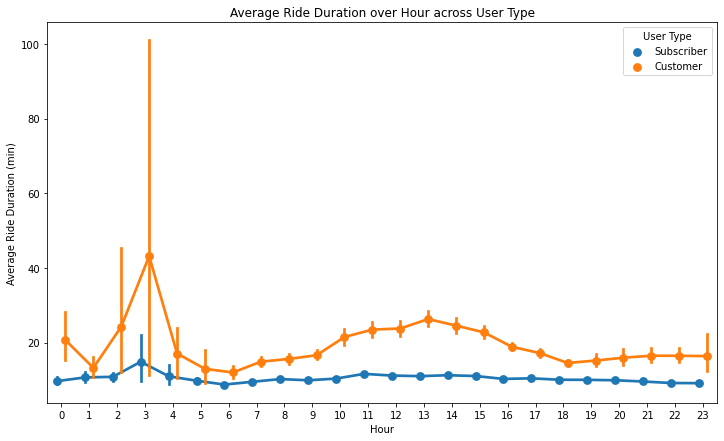

In [17]:
plt.figure(figsize=[12, 7])

sb.pointplot(data=df, x='start_hour', y='duration_min', hue='user_type', dodge=0.3, linestyles="-")
plt.title('Average Ride Duration over Hour across User Type')
plt.xlabel('Hour');
plt.legend(title='User Type')
plt.ylabel('Average Ride Duration (min)')

plt.show()

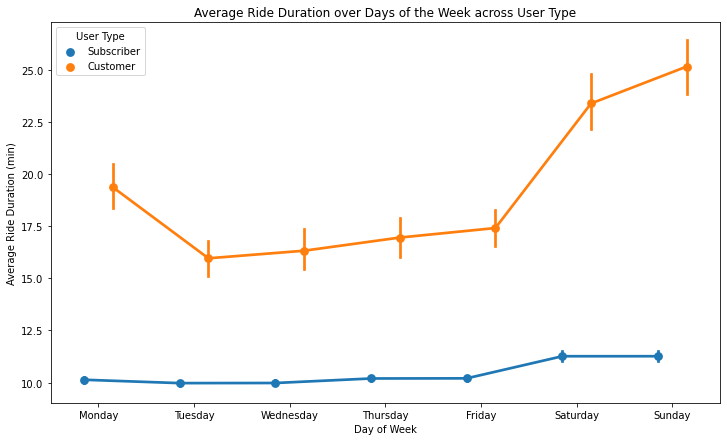

In [18]:
plt.figure(figsize=[12, 7])

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.pointplot(data=df, x='start_day', y='duration_min', hue='user_type', dodge=0.3, linestyles="-", order=weekdays)
plt.title('Average Ride Duration over Days of the Week across User Type')
plt.xlabel('Day of Week');
plt.legend(title='User Type')
plt.ylabel('Average Ride Duration (min)')

plt.show()

In [ ]:
!jupyter nbconvert fordgobike_data_exploration_part2.ipynb --to slides --post serve --no-input --no-prompt